# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import scipy.io
import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from skimage.metrics import structural_similarity as cal_ssim
from utils.denoising_utils import *

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
dtype = torch.FloatTensor

sigma = 100
sigma_ = sigma/255.

# Load image

In [2]:
file_name  = 'data/denoising/KSC_50.mat'
# ensure dimensions [0][1] are divisible by 32 (or 2^depth)!

mat = scipy.io.loadmat(file_name)
img_np = mat["gt"]
img_np = img_np.transpose(2,0,1)
img_var = torch.from_numpy(img_np).type(dtype)
# img_noisy_np = get_noisy_image(img_np, sigma_)
# img_noisy_var = torch.from_numpy(img_noisy_np).type(dtype)
img_noisy_np = mat["input"]
img_noisy_np = img_noisy_np.transpose(2,0,1)
img_noisy_var = torch.from_numpy(img_noisy_np).type(dtype)


### Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


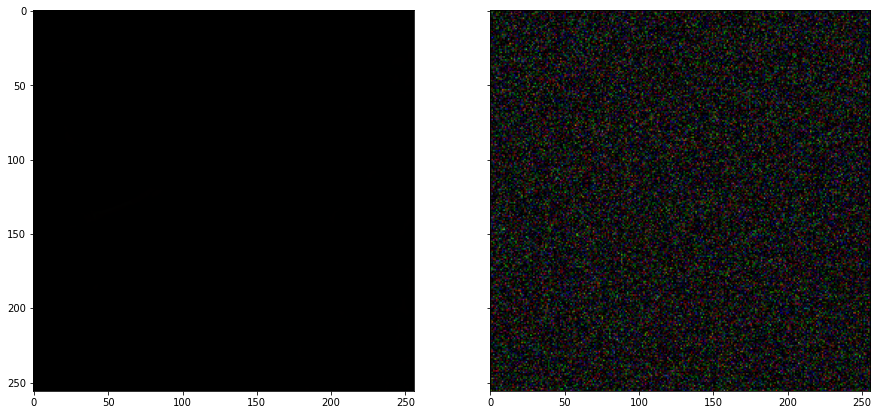

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(torch.stack((img_var[56,:,:].cpu(),img_var[26,:,:].cpu(),img_var[16,:,:].cpu()),2))
ax2.imshow(torch.stack((img_noisy_var[56,:,:].cpu(),img_noisy_var[26,:,:].cpu(),img_noisy_var[16,:,:].cpu()),2))
plt.show()

# Setup

In [4]:
method = '2D'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 0.03 # 0 0.01 0.05 0.08
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
exp_weight=0.99

show_every = 200
save_every = 200

num_iter = 1801
input_depth = img_np.shape[0]  

net = skip(input_depth, img_np.shape[0],  
       num_channels_down = [128]*5,
       num_channels_up =   [128]*5,
       num_channels_skip =    [4]*5,  
       filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
       upsample_mode='bilinear', # downsample_mode='avg',
       need1x1_up=False,
       need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    
net_input = get_noise(input_depth, method, (img_np.shape[1], img_np.shape[2])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_var = img_noisy_var[None, :]

Number of params: 2322772


# Optimize

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_var)
    total_loss.backward()
    
    out_np = out.detach().cpu().squeeze().numpy()
    out_avg_np = out_avg.detach().cpu().squeeze().numpy()

    psrn_noisy = compare_psnr(img_noisy_np.astype(np.float32), np.clip(out_np, 0, 1), data_range=1.0)  
    psrn_gt    = compare_psnr(img_np.astype(np.float32), np.clip(out_np, 0, 1),data_range=1.0) 
    psrn_gt_sm = compare_psnr(img_np.astype(np.float32), np.clip(out_avg_np, 0, 1),data_range=1.0) 
    ssim_gt = cal_ssim(img_np.astype(np.float32), np.clip(out_np, 0, 1),data_range=1.0)
    ssim_gt_sm = cal_ssim(img_np.astype(np.float32), np.clip(out_avg_np, 0, 1),data_range=1.0)
    
    
    print ('Iteration %05d    Loss %f  PSRN_gt: %f PSNR_gt_sm: %f SSIM_gt: %f SSIM_gt_sm: %f' % (i, total_loss.item(), psrn_gt, psrn_gt_sm, ssim_gt, ssim_gt_sm), '\r', end='')
    if i % show_every == 0:
        out_np = np.clip(out_np, 0, 1)
        out_avg_np = np.clip(out_avg_np, 0, 1)
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
        ax1.imshow(np.stack((out_np[56,:,:],out_np[26,:,:],out_np[16,:,:]),2))
        ax2.imshow(np.stack((out_avg_np[56,:,:],out_avg_np[26,:,:],out_avg_np[16,:,:]),2))
        plt.show()
    
    #if  i % save_every == 0:
       # scipy.io.savemat("results/result_denoising_2D_it%05d.mat" % (i), {'pred':out_np.transpose(1,2,0),
      #                                                                        'pred_avg':out_avg_np.transpose(1,2,0)})
        
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.detach().copy_(new_param)

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


/root/miniconda3/envs/dip/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/root/miniconda3/envs/dip/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [30]:
from skimage.metrics import structural_similarity as cal_ssim
ssim = cal_ssim(img_np.astype(np.float32), np.clip(img_noisy_np, 0, 1),data_range=1.0)
print(ssim)

0.04502991073488042
